In [1]:
import os
import random
import shutil
from tqdm import tqdm
import kagglehub
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D,
    GlobalAveragePooling2D, Dense, Input, Dropout
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import PIL.Image

In [2]:
# Download the dataset
path = kagglehub.dataset_download("hearfool/vggface2")
print("Path to dataset files:", path)

100%|██████████| 2.32G/2.32G [00:31<00:00, 78.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hearfool/vggface2/versions/1


In [3]:
# Parameters
NUM_CLASSES = 40
IMAGES_PER_CLASS = 200
TRAIN_RATIO = 0.8
IMG_SIZE = (112, 112)
BATCH_SIZE = 4
AUTOTUNE = tf.data.AUTOTUNE

# Define directories
original_dir = os.path.join(path, "train")
output_dir = "vggface2_split"
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")

# Create output directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [4]:
# Get all class directories
classes = [d for d in os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir, d))]

# Select 40 classes randomly
selected_classes = random.sample(classes, NUM_CLASSES)

for cls in tqdm(selected_classes, desc="Processing classes"):
    cls_path = os.path.join(original_dir, cls)
    images = [img for img in os.listdir(cls_path) if img.endswith(".jpg")]

    # Ensure we have at least 200 images
    if len(images) < IMAGES_PER_CLASS:
        print(f"Skipping class {cls} (not enough images)")
        continue

    # Randomly select 200 images
    selected_images = random.sample(images, IMAGES_PER_CLASS)

    # Split into train and test
    split_index = int(TRAIN_RATIO * IMAGES_PER_CLASS)
    train_images = selected_images[:split_index]
    test_images = selected_images[split_index:]

    # Copy to train directory
    train_cls_dir = os.path.join(train_dir, cls)
    os.makedirs(train_cls_dir, exist_ok=True)
    for img in train_images:
        shutil.copy(os.path.join(cls_path, img), os.path.join(train_cls_dir, img))

    # Copy to test directory
    test_cls_dir = os.path.join(test_dir, cls)
    os.makedirs(test_cls_dir, exist_ok=True)
    for img in test_images:
        shutil.copy(os.path.join(cls_path, img), os.path.join(test_cls_dir, img))

print("Dataset split completed. ")

Processing classes:  42%|████▎     | 17/40 [00:00<00:00, 49.61it/s]

Skipping class n000093 (not enough images)
Skipping class n000135 (not enough images)


Processing classes: 100%|██████████| 40/40 [00:00<00:00, 46.04it/s]

Dataset split completed.


In [5]:
# Preprocessing function with Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

def preprocess_with_augmentation(features, labels):
    features = tf.cast(features, tf.float32) / 255.0  # Normalize
    features = data_augmentation(features)
    return features, labels

def load_images_from_directory(folder_path, img_size=(112, 112)):
    labels = []
    images = []
    class_names = sorted(os.listdir(folder_path))
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        for filename in os.listdir(class_folder):
            if filename.endswith(('.tif', '.jpg', '.png')):
                img_path = os.path.join(class_folder, filename)
                try:
                    img = PIL.Image.open(img_path).convert("RGB")
                    img = img.resize(img_size)  # Resize image
                    img_array = np.array(img)
                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image: {img_path}")
                    continue
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, class_names

def create_tf_datasets():
    train_ds, train_labels, train_classes = load_images_from_directory(train_dir, IMG_SIZE)
    test_ds, test_labels, _ = load_images_from_directory(test_dir, IMG_SIZE)

    train_tensor_ds = tf.data.Dataset.from_tensor_slices((train_ds, train_labels))
    train_tensor_ds = train_tensor_ds.map(preprocess_with_augmentation).shuffle(5000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

    test_tensor_ds = tf.data.Dataset.from_tensor_slices((test_ds, test_labels))
    test_tensor_ds = test_tensor_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

    return train_tensor_ds, test_tensor_ds, train_classes

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Generate TensorFlow datasets
train_ds, test_ds, class_names = create_tf_datasets()
num_classes = len(class_names)

# Build and compile the model
input_shape = IMG_SIZE + (3,)
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the pre-trained Xception model without the top layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
# Freeze the layers in the base model
base_model.trainable = False
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Callbacks for Early Stopping and Model Checkpoint
checkpoint_path = "/content/drive/My Drive/Deep Learning/final/checkpoint.keras"
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    verbose=1
)

early_stopping_cb = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

# Save the final model
model.save("/content/drive/My Drive/Deep Learning/final/model3.h5")
print("Model training completed and saved.")

Epoch 1/3
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1990 - loss: 2.9764
Epoch 1: val_loss improved from inf to 2.17271, saving model to /content/drive/My Drive/Deep Learning/final/checkpoint.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 65s 21ms/step - accuracy: 0.1990 - loss: 2.9762 - val_accuracy: 0.3730 - val_loss: 2.1727
Epoch 2/3
1518/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3554 - loss: 2.1759
Epoch 2: val_loss improved from 2.17271 to 1.97771, saving model to /content/drive/My Drive/Deep Learning/final/checkpoint.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 52s 18ms/step - accuracy: 0.3554 - loss: 2.1758 - val_accuracy: 0.4197 - val_loss: 1.9777
Epoch 3/3
1515/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4154 - loss: 1.9988
Epoch 3: val_loss improved from 1.97771 to 1.92711, saving model to /content/drive/My Drive/Deep Learning/final/checkpoint.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 76s 15ms/step - accuracy: 0.4154 - loss: 1.9988 - val_accuracy: 0.4368 - val_los

Model training completed and saved.


In [9]:
# Additional training
new_history1 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=6,
    initial_epoch=3,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
model.save("/content/drive/My Drive/Deep Learning/final/model3.h5")
print("Model training completed and saved.")

Epoch 4/6
1519/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4527 - loss: 1.8857
Epoch 4: val_loss improved from 1.92711 to 1.89603, saving model to /content/drive/My Drive/Deep Learning/final/checkpoint.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - accuracy: 0.4526 - loss: 1.8857 - val_accuracy: 0.4625 - val_loss: 1.8960
Epoch 5/6
1516/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4647 - loss: 1.7910
Epoch 5: val_loss improved from 1.89603 to 1.80794, saving model to /content/drive/My Drive/Deep Learning/final/checkpoint.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 47s 16ms/step - accuracy: 0.4647 - loss: 1.7911 - val_accuracy: 0.4789 - val_loss: 1.8079
Epoch 6/6
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4841 - loss: 1.7205
Epoch 6: val_loss did not improve from 1.80794
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - accuracy: 0.4841 - loss: 1.7206 - val_accuracy: 0.4724 - val_loss: 1.8285


Model training completed and saved.


In [12]:
# Additional training
new_history2 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=9,
    initial_epoch=6,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
model.save("/content/drive/My Drive/Deep Learning/final/model3.h5")
print("Model training completed and saved.")

Epoch 7/9
1519/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5001 - loss: 1.6959
Epoch 7: val_loss did not improve from 1.80794
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - accuracy: 0.5001 - loss: 1.6959 - val_accuracy: 0.4888 - val_loss: 1.8380
Epoch 8/9
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5234 - loss: 1.6228
Epoch 8: val_loss improved from 1.80794 to 1.80460, saving model to /content/drive/My Drive/Deep Learning/final/checkpoint.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 80s 15ms/step - accuracy: 0.5234 - loss: 1.6228 - val_accuracy: 0.5020 - val_loss: 1.8046
Epoch 9/9
1517/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5341 - loss: 1.5762
Epoch 9: val_loss improved from 1.80460 to 1.79484, saving model to /content/drive/My Drive/Deep Learning/final/checkpoint.keras
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - accuracy: 0.5341 - loss: 1.5763 - val_accuracy: 0.4954 - val_loss: 1.7948


Model training completed and saved.


In [15]:
# Additional training
new_history3 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=12,
    initial_epoch=9,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
model.save("/content/drive/My Drive/Deep Learning/final/model3.h5")
print("Model training completed and saved.")

Epoch 10/12
1516/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5337 - loss: 1.5747
Epoch 10: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 54s 19ms/step - accuracy: 0.5337 - loss: 1.5747 - val_accuracy: 0.4987 - val_loss: 1.8946
Epoch 11/12
1516/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5598 - loss: 1.4923
Epoch 11: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 46s 15ms/step - accuracy: 0.5598 - loss: 1.4924 - val_accuracy: 0.4816 - val_loss: 1.9288
Epoch 12/12
1515/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5572 - loss: 1.4875
Epoch 12: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 84s 16ms/step - accuracy: 0.5572 - loss: 1.4876 - val_accuracy: 0.4947 - val_loss: 1.8814


Model training completed and saved.


In [18]:
# Additional training
new_history4 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=16,
    initial_epoch=12,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
model.save("/content/drive/My Drive/Deep Learning/final/model3.h5")
print("Model training completed and saved.")

Epoch 13/16
1517/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5721 - loss: 1.4375
Epoch 13: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 46s 15ms/step - accuracy: 0.5721 - loss: 1.4377 - val_accuracy: 0.4954 - val_loss: 1.8940
Epoch 14/16
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5739 - loss: 1.4411
Epoch 14: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - accuracy: 0.5739 - loss: 1.4411 - val_accuracy: 0.5086 - val_loss: 1.8436
Epoch 15/16
1519/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5871 - loss: 1.4021
Epoch 15: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 81s 16ms/step - accuracy: 0.5871 - loss: 1.4022 - val_accuracy: 0.5020 - val_loss: 1.9445
Epoch 16/16
1517/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5848 - loss: 1.3926
Epoch 16: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 46s 16ms/step - accuracy: 0.5848 - loss: 1.3926 - val_

Model training completed and saved.


In [21]:
# Additional training
new_history5 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    initial_epoch=16,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
model.save("/content/drive/My Drive/Deep Learning/final/model3.h5")
print("Model training completed and saved.")

Epoch 17/20
1519/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5924 - loss: 1.3765
Epoch 17: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - accuracy: 0.5924 - loss: 1.3765 - val_accuracy: 0.5112 - val_loss: 1.8596
Epoch 18/20
1515/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6035 - loss: 1.3132
Epoch 18: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 47s 16ms/step - accuracy: 0.6034 - loss: 1.3135 - val_accuracy: 0.5151 - val_loss: 1.9657
Epoch 19/20
1517/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5974 - loss: 1.3118
Epoch 19: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 84s 17ms/step - accuracy: 0.5974 - loss: 1.3119 - val_accuracy: 0.5118 - val_loss: 1.9633
Epoch 20/20
1516/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5951 - loss: 1.3760
Epoch 20: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 80s 15ms/step - accuracy: 0.5951 - loss: 1.3759 - val_

Model training completed and saved.


In [24]:
# Additional training
new_history6 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=25,
    initial_epoch=20,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
model.save("/content/drive/My Drive/Deep Learning/final/model3.h5")
print("Model training completed and saved.")

Epoch 21/25
1517/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6174 - loss: 1.2730
Epoch 21: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - accuracy: 0.6174 - loss: 1.2731 - val_accuracy: 0.4980 - val_loss: 1.9667
Epoch 22/25
1517/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6177 - loss: 1.2894
Epoch 22: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 79s 16ms/step - accuracy: 0.6177 - loss: 1.2895 - val_accuracy: 0.5079 - val_loss: 2.0310
Epoch 23/25
1519/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6122 - loss: 1.2866
Epoch 23: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - accuracy: 0.6122 - loss: 1.2866 - val_accuracy: 0.5066 - val_loss: 1.9783
Epoch 24/25
1515/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6167 - loss: 1.2909
Epoch 24: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 46s 15ms/step - accuracy: 0.6167 - loss: 1.2909 - val_

Model training completed and saved.


In [27]:
# Additional training
new_history7 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=30,
    initial_epoch=25,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
model.save("/content/drive/My Drive/Deep Learning/final/model3.h5")
print("Model training completed and saved.")

Epoch 26/30
1518/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6259 - loss: 1.3047
Epoch 26: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 46s 15ms/step - accuracy: 0.6259 - loss: 1.3047 - val_accuracy: 0.5033 - val_loss: 2.0157
Epoch 27/30
1518/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6318 - loss: 1.2428
Epoch 27: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 47s 15ms/step - accuracy: 0.6318 - loss: 1.2429 - val_accuracy: 0.5125 - val_loss: 1.9829
Epoch 28/30
1516/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6574 - loss: 1.1736
Epoch 28: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 84s 17ms/step - accuracy: 0.6574 - loss: 1.1739 - val_accuracy: 0.5132 - val_loss: 2.0113
Epoch 29/30
1517/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6433 - loss: 1.2071
Epoch 29: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 82s 17ms/step - accuracy: 0.6433 - loss: 1.2072 - val_

Model training completed and saved.


In [30]:
for layer in base_model.layers:
    layer.trainable = True

In [31]:
# Additional training
new_history8 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=33,
    initial_epoch=30,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
model.save("/content/drive/My Drive/Deep Learning/final/model3.h5")
print("Model training completed and saved.")

Epoch 31/33
1517/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6400 - loss: 1.1950
Epoch 31: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 47s 16ms/step - accuracy: 0.6400 - loss: 1.1951 - val_accuracy: 0.5145 - val_loss: 2.0027
Epoch 32/33
1518/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6505 - loss: 1.1550
Epoch 32: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - accuracy: 0.6505 - loss: 1.1551 - val_accuracy: 0.5092 - val_loss: 2.0816
Epoch 33/33
1518/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6617 - loss: 1.1599
Epoch 33: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 84s 17ms/step - accuracy: 0.6617 - loss: 1.1599 - val_accuracy: 0.5007 - val_loss: 2.1135


Model training completed and saved.


In [34]:
# Additional training
new_history9 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=37,
    initial_epoch=33,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
model.save("/content/drive/My Drive/Deep Learning/final/model3.h5")
print("Model training completed and saved.")

Epoch 34/37
1515/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6552 - loss: 1.1535
Epoch 34: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 46s 16ms/step - accuracy: 0.6551 - loss: 1.1537 - val_accuracy: 0.5079 - val_loss: 2.0713
Epoch 35/37
1516/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6628 - loss: 1.1493
Epoch 35: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - accuracy: 0.6628 - loss: 1.1494 - val_accuracy: 0.4987 - val_loss: 2.0559
Epoch 36/37
1518/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6682 - loss: 1.1243
Epoch 36: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 79s 15ms/step - accuracy: 0.6681 - loss: 1.1244 - val_accuracy: 0.5046 - val_loss: 2.0665
Epoch 37/37
1517/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6597 - loss: 1.1587
Epoch 37: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - accuracy: 0.6596 - loss: 1.1587 - val_

Model training completed and saved.


In [37]:
# Additional training
new_history10 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=40,
    initial_epoch=37,
    callbacks=[checkpoint_cb]
)

# Save the updated training history
# Save the model
model.save("/content/drive/My Drive/Deep Learning/final/model3.h5")
print("Model training completed and saved.")

Epoch 38/40
1518/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6719 - loss: 1.1351
Epoch 38: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - accuracy: 0.6718 - loss: 1.1352 - val_accuracy: 0.4967 - val_loss: 2.2833
Epoch 39/40
1515/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6613 - loss: 1.1377
Epoch 39: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 47s 15ms/step - accuracy: 0.6613 - loss: 1.1378 - val_accuracy: 0.5039 - val_loss: 2.2355
Epoch 40/40
1516/1520 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6735 - loss: 1.1433
Epoch 40: val_loss did not improve from 1.79484
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 56s 16ms/step - accuracy: 0.6735 - loss: 1.1434 - val_accuracy: 0.5092 - val_loss: 2.2379


Model training completed and saved.


In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate model predictions on the test dataset
y_true = []
y_pred = []
y_pred_probs = []

# Iterate over the test dataset to collect predictions and true labels
for features, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(model.predict(features))
    y_pred.extend(np.argmax(model.predict(features), axis=-1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_probs = np.array(y_pred_probs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

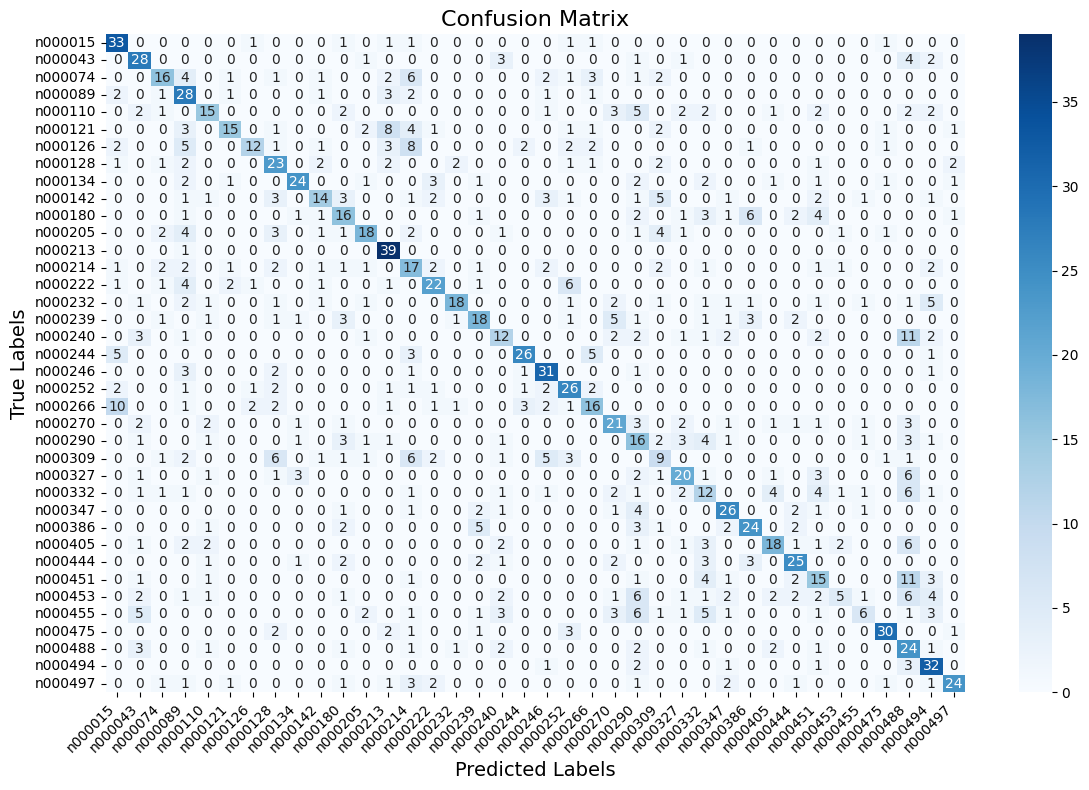

In [39]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


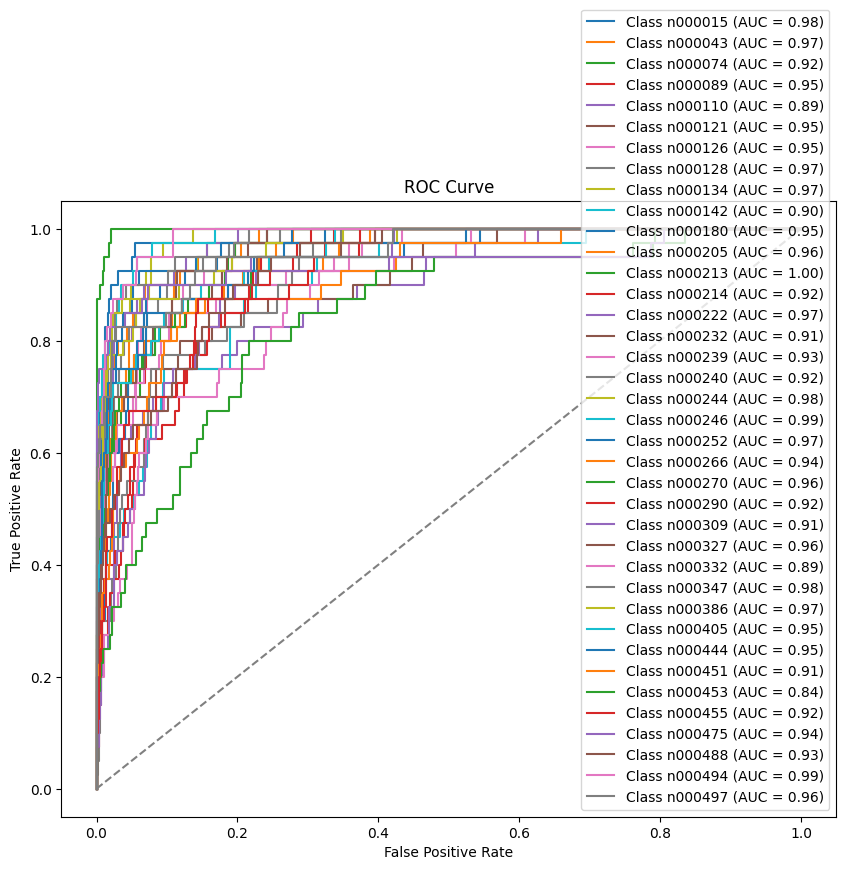

Macro-Average ROC AUC: 0.94


In [40]:
# Compute ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Add random chance line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Compute overall macro-average ROC AUC
macro_roc_auc = roc_auc_score(y_true, y_pred_probs, multi_class="ovr", average="macro")
print(f"Macro-Average ROC AUC: {macro_roc_auc:.2f}")

In [41]:
# Merge histories from all training phases
def combine_histories(*histories):
    combined_history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    for hist in histories:
        for key in combined_history.keys():
            combined_history[key].extend(hist.history[key])
    return combined_history

# Combine histories
full_history = combine_histories(history, new_history1, new_history2, new_history3, new_history4 , new_history6 , new_history6 , new_history6, new_history6 , new_history6,new_history7,new_history8,new_history9,new_history10)

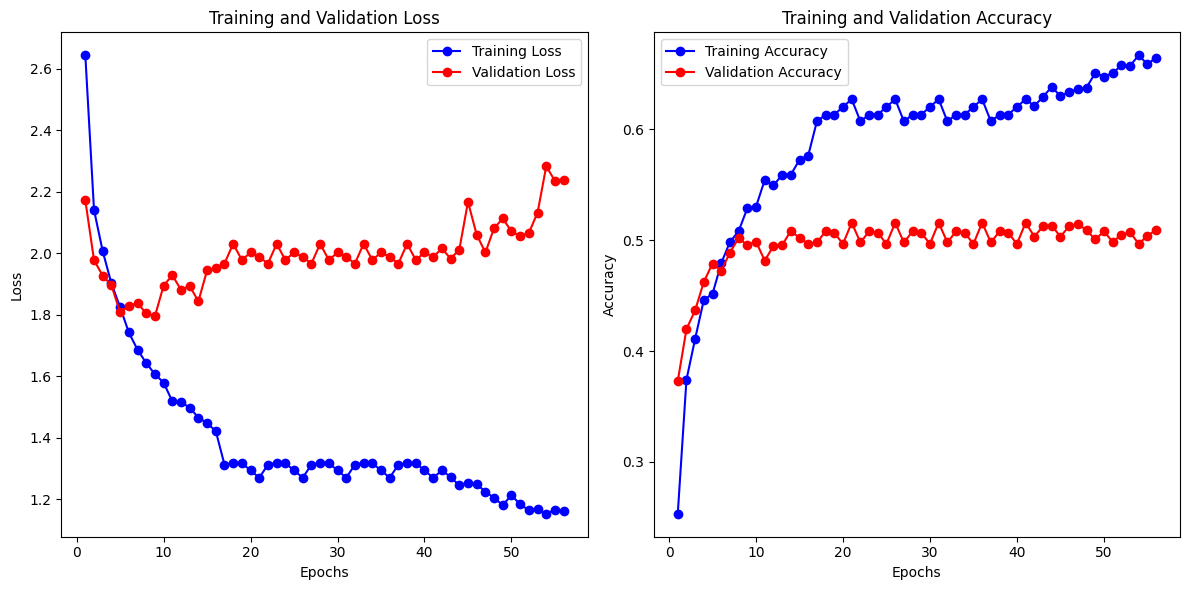

In [42]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics
def plot_full_training_history(full_history):
    epochs = range(1, len(full_history['loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, full_history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, full_history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, full_history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, full_history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the combined training history
plot_full_training_history(full_history)


In [43]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

     n000015     0.5789    0.8250    0.6804        40
     n000043     0.5490    0.7000    0.6154        40
     n000074     0.5714    0.4000    0.4706        40
     n000089     0.3889    0.7000    0.5000        40
     n000110     0.5172    0.3750    0.4348        40
     n000121     0.6818    0.3750    0.4839        40
     n000126     0.7059    0.3000    0.4211        40
     n000128     0.4510    0.5750    0.5055        40
     n000134     0.7500    0.6000    0.6667        40
     n000142     0.5600    0.3500    0.4308        40
     n000180     0.4000    0.4000    0.4000        40
     n000205     0.6207    0.4500    0.5217        40
     n000213     0.6000    0.9750    0.7429        40
     n000214     0.2787    0.4250    0.3366        40
     n000222     0.6111    0.5500    0.5789        40
     n000232     0.7826    0.4500    0.5714        40
     n000239     0.5455    0.4500    0.4932        40
    